# Atari Game- Assault

### Importing the packages

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import gc
import os
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F


### Defining the CNN Model

In [7]:
class Model(nn.Module):

    def __init__(self, in_features=3, num_classes=7):
        super(Model, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=32, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride=1, padding=1),
            nn.Softplus(),
            nn.Conv2d(16,1, kernel_size=3,stride=1, padding=1),
            
        
        )

        with torch.no_grad():
            dummy_input = torch.randn( in_features,210,160)
            dummy_output = self.conv_block(dummy_input)
            flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1)

        self.linear_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Change the number of output units to num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.linear_block(x)
        return x

### Defining the replay memory as a deque

In [8]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)


### The heart of the code which contains the class AssaultDQL which contains two main function test and train

In [9]:
class AssaultDQL():
    # Hyperparameters (adjustable)
    augmentations = transforms.Compose([transforms.ToTensor()])
    learning_rate_a = 0.01         # learning rate (alpha)
    discount_factor_g = 0.75         # discount rate (gamma)    
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 500      # size of replay memory
    mini_batch_size = 64       # size of the training data set sampled from the replay memory
    
    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.
    def train(self, episodes, render="None"):
        # Create FrozenLake instance
        env = gym.make("ALE/Assault-v5",  render_mode=render if render else None)
        
        
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = Model()
        target_dqn = Model()
        target_dqn.load_state_dict(policy_dqn.state_dict())
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       
            ''' flag=0
            flag+=1  
            if(flag==100):
                print(i)
                flag=0'''
            print(i)
            total_reward=0
            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    # select best action            
                    with torch.no_grad():
                        augmentations = transforms.Compose([transforms.ToTensor()])
                        action = policy_dqn(augmentations(state))[0].argmax().item()
            
                new_state, reward, terminated, truncated,_ = env.step(action)
                memory.append((state, action, new_state, reward, terminated)) 
                step_count+=1
                total_reward+=reward
            
            if total_reward > 0.0:
                rewards_per_episode[i] = total_reward
            print(len(memory)>self.mini_batch_size)
            print(rewards_per_episode[i])
            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        
       # Save policy
        torch.save(policy_dqn.state_dict(), "Assault_dql.pt")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(rewards_per_episode)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('Assault_graph.png')
        
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated or reward>0.0: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    augmentations = transforms.Compose([transforms.ToTensor()])
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(augmentations(new_state))[0].max()
                    )

            # Get the current set of Q values
            augmentations = transforms.Compose([transforms.ToTensor()])
            current_q = policy_dqn(augmentations(state))[0]
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(augmentations(state))[0]
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def test(self, episodes):
        # Create FrozenLake instance
        env = gym.make("ALE/Assault-v5",  render_mode='human' )
      

        # Load learned policy
        policy_dqn = Model() 
        policy_dqn.load_state_dict(torch.load("Assault_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    augmentations = transforms.Compose([transforms.ToTensor()])
                    action = policy_dqn(augmentations(state))[0].argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()


## Training

#### Due to large training time and low computational power, have run only 100 episodes even that took 4 hours

0
True
231.0
1
True
336.0
2
True
252.0
3
True
105.0
4
True
189.0
5
True
189.0
6
True
231.0
7
True
252.0
8
True
294.0
9
True
210.0
10
True
231.0
11
True
294.0
12
True
273.0
13
True
189.0
14
True
273.0
15
True
168.0
16
True
189.0
17
True
189.0
18
True
231.0
19
True
336.0
20
True
189.0
21
True
189.0
22
True
336.0
23
True
252.0
24
True
231.0
25
True
378.0
26
True
315.0
27
True
210.0
28
True
378.0
29
True
336.0
30
True
357.0
31
True
252.0
32
True
273.0
33
True
231.0
34
True
315.0
35
True
63.0
36
True
147.0
37
True
147.0
38
True
189.0
39
True
63.0
40
True
189.0
41
True
399.0
42
True
315.0
43
True
105.0
44
True
357.0
45
True
168.0
46
True
189.0
47
True
168.0
48
True
63.0
49
True
231.0
50
True
126.0
51
True
315.0
52
True
567.0
53
True
483.0
54
True
294.0
55
True
63.0
56
True
378.0
57
True
252.0
58
True
210.0
59
True
315.0
60
True
294.0
61
True
126.0
62
True
105.0
63
True
189.0
64
True
420.0
65
True
231.0
66
True
189.0
67
True
273.0
68
True
336.0
69
True
189.0
70
True
504.0
71
True
378.0
72
Tru

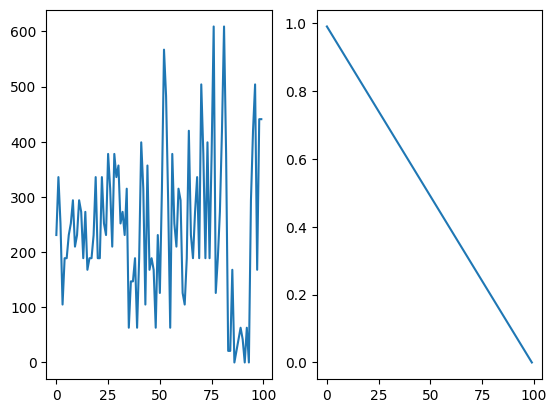

In [10]:
if __name__ == '__main__':

    atari = AssaultDQL()
    
    atari.train(100, render=False)
   


#### Testing by rendering


In [11]:
#frozen_lake = AssaultDQN()
atari = AssaultDQL()
atari.test(1)

Policy (trained):


##### Dummy code to know the enviroment

In [ ]:
env = gym.make("ALE/Assault-v5", render_mode="human")
observation, info = env.reset()

for i in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(truncated, reward)
    '''
    observation=observation/255
    observation = np.float32(observation)
    obs_tensor=torch.from_numpy(observation)
    print(obs_tensor.size())
    test=Model()
    obs_tensor=torch.utils.data.DataLoader(obs_tensor,
                                            batch_size = 1,
                                            
                                              num_workers = 2
                                              )
    print(obs_tensor)
    #obs_tensor= torch.utils.data.TensorDataset(torch.tensor(obs_tensor))'''

    augmentations = transforms.Compose([transforms.ToTensor()])
    test=Model()
    obs_tensor=augmentations(observation)
    print(test(obs_tensor))
    
    
    if terminated or truncated:
        observation, info = env.reset()

env.close()

False 0.0
tensor([[-0.0527,  0.0551, -0.0160,  0.0763,  0.0627, -0.0774, -0.0195]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.1375, -0.0313, -0.0029,  0.0768, -0.0811, -0.0295, -0.0090]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.0303, -0.0899, -0.1034, -0.0549,  0.0897,  0.0741, -0.0245]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[ 0.0191, -0.0922, -0.2459,  0.2268,  0.0473,  0.2517,  0.1629]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.0836,  0.1373,  0.1044, -0.0058,  0.0138,  0.0798, -0.0802]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.0903, -0.0790,  0.0491, -0.0387, -0.1034,  0.1231, -0.0759]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.1173,  0.1684, -0.0205,  0.1077, -0.1257,  0.0273, -0.1147]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[-0.0327, -0.0606, -0.0896, -0.1619, -0.0185,  0.0722,  0.1006]],
       grad_fn=<AddmmBackward0>)
False 0.0
tensor([[ 0.0542,  0.0558,  0.1142, -0.1250, -0.1238, 

KeyboardInterrupt: 